In [955]:
import numpy as np              
import matplotlib.pyplot as plt 

# Lorenz 96 Model

Equation:

$$\frac{dx_i}{dt} = (x_{i+1} - x_{i-2}) \cdot x_{i-1} - x_i + F$$

## Breakdown on the equation
1. $(x_{i+1} - x_{i-2}) \cdot x_{i-1}$ : Advection term 

    This term represents the nonlinear transport which creates energy transfer between spatial locations

2. $-x_i$ : Diffusion(Damping)

    This term prevents infinite growth of the system which represents the energy dissipation.

3. $F$ : Forcing

    This term balances the dissipation which represents the external force applied to the system.

In [956]:
def l96(x, t, F = 8.0):
    n = len(x)
    dxdt = np.zeros(n)

    for i in range(n):
        i_p_1 = (i + 1) % n
        i_m_2 = (i - 2) % n
        i_m_1 = (i - 1) % n

        dxdt[i] = (x[i_p_1] - x[i_m_2]) * x[i_m_1] - x[i] + F
    
    return dxdt


# Runge-Kutta 4th Order Method

Equation:

$$y(t_0 + h) = y(t_0) + \frac{k_1+2k_2+2k_3+k_4}{6} \cdot h$$

where
$$k_1 = f(y(t_0), t_0)$$
$$k_2 = f(y(t_0) + k_1 \cdot \frac{h}{2}, t_0 + \frac{h}{2})$$
$$k_3 = f(y(t_0) + k_2 \cdot \frac{h}{2}, t_0+ \frac{h}{2})$$
$$k_4 = f(y(t_0) + k_3 \cdot h, t_0 + h)$$

But since Lorenz 96 model is autonomous function we keep out the time from the code implementation.


In [957]:
def RK4(f, x0, h, F):
    
    k1 = f(x0, None, F)
    k2 = f(x0 + k1 * h / 2.0, None, F) 
    k3 = f(x0 + k2 * h / 2.0, None, F)
    k4 = f(x0 + k3 * h, None, F) 

    x = x0 + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return x

# Generating Truth Data

In this section, we generate "truth" data for the chaotic model.

1. Set up the intial conditon with random noise. This function will output x0 which is the initial condition that will be used on spin up model.

2. Before collecting data, we must go through spin-up phase to remove influence of the arbitrary inital condition.

3. Run lorenz-96 simulation using spin-up state as starting point.

    This function outputs
    - T : A 1D NumPy array where it holds the time points
    - X : A 2D NumPy array where it contains the full system state for each step

In [958]:
def initial_conditions(n, F):
    x0 = np.ones(n) * F + np.random.randn(n) * 0.01
    return x0

def spin_up_model(x0, h, F, t_spin):
    spin_steps = int(t_spin / h)
    x_spin = x0.copy()
    for _ in range(spin_steps):
        x_spin = RK4(l96, x_spin, h, F)
    return x_spin

def simulate_l96(x_spin, h, h_obs, F, t_total):
    n = len(x_spin)
    total_steps = int(t_total / h_obs)
    obs_steps = int(h_obs / h)

    X = np.zeros((total_steps + 1, n))
    T = np.zeros(total_steps + 1)

    X[0] = x_spin
    T[0] = 0.0
    x = x_spin.copy()

    for j in range(total_steps):
        for _ in range(obs_steps):
            x = RK4(l96, x, h, F)
        X[j + 1] = x
        T[j + 1] = (j + 1) * h_obs

    return T, X


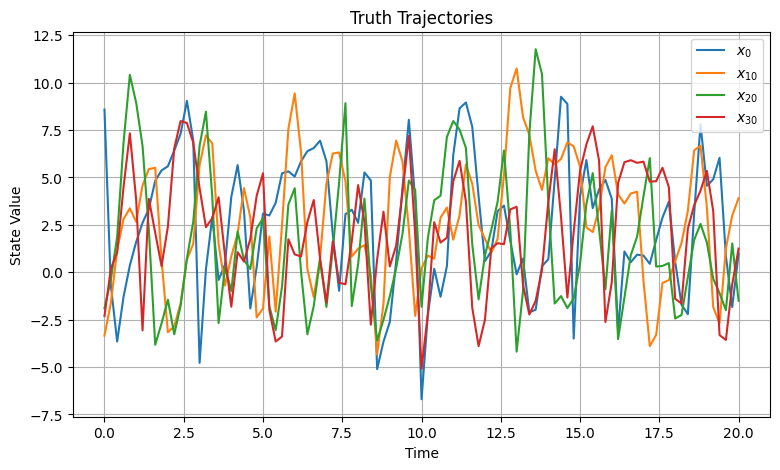

In [959]:
#Testing Parameters
n = 40
F = 8.0
h = 0.05
h_obs = 0.2
t_spin = 5.0
t_total = 20.0

x0 = initial_conditions(n, F)
x_spin = spin_up_model(x0, h, F, t_spin)
t_truth, X_truth = simulate_l96(x_spin, h, h_obs, F, t_total)




plt.figure(figsize=(9, 5)) 
for j in range(0, 40, 10):
    plt.plot(t_truth, X_truth[:, j], label=f'$x_{{{j}}}$') 

plt.title('Truth Trajectories') 
plt.legend()   
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('State Value')

plt.show()


# Generating Observation from the Truth Data

1. Selects which spatial points will be observed. This function outputs a 1D arry of indices.

2. Constructs the observation operator matrix H in a linear Gaussian observation model as following

$$y_t = H_t x_t + v_t, \quad v_t \sim \mathcal{N}(0, R_t)$$

where $y_t$: measurement vector in $\mathbb{R}^{m}$, $H_t$: observation matrix in $\mathbb{R}^{m \times n}$, $x_t$: truth data in $\mathbb{R}^{n}$, and $v_t$: a Gausian noise in $\mathbb{R}^{m}$

3. Generates gaussian noise with standard deviation from truth data. This function outputs a 2D array of (time steps, # of observed variables).

In [960]:
def observation_index(n, obs_space):
    obs_idx = np.arange(0, n, obs_space)
    return obs_idx

def observation_matrix(obs_idx, n):
    m = len(obs_idx)
    H = np.zeros((m, n))
    for i in range(m):
        H[i, obs_idx[i]] = 1
    return H

def observation_noise_cov_matrix(obs_idx, sigma_obs):
    m = len(obs_idx)  # number of observed variables
    R = sigma_obs**2 * np.eye(m)
    return R

def noise_to_observations(X_truth, obs_idx, sigma_obs):
    n_times = X_truth.shape[0]
    Y = X_truth[:, obs_idx]
    noise = np.random.randn(n_times, len(obs_idx)) * sigma_obs
    Y = Y + noise
    return Y

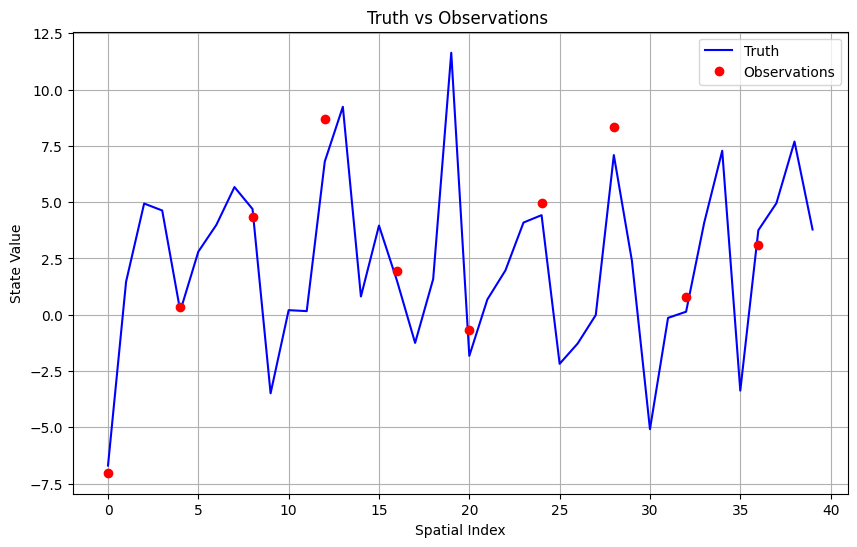

In [961]:
#Testing parameters
n = 40
obs_space = 4
sigma_obs = 1.0 

obs_idx = observation_index(n, obs_space)
H = observation_matrix(obs_idx, n)
R = observation_noise_cov_matrix(obs_idx, sigma_obs)
Y = noise_to_observations(X_truth, obs_idx, sigma_obs)



k = 50 
plt.figure(figsize=(10, 6))
plt.plot(range(40), X_truth[k, :], 'b-', label='Truth')
plt.plot(obs_idx, Y[k, :], 'ro', label='Observations')

plt.title(f'Truth vs Observations ')
plt.legend()
plt.grid(True)
plt.xlabel('Spatial Index')
plt.ylabel('State Value')



plt.show()

# Ensemble Kalman Filter Algorithm

The Ensemble Kalman Filter Algorithm is a Monte Carlo approximation of the Kalman filter that represents the distribution using an ensemble of state vector instead of computing covariance matrix explicitly.


Ensemble is a collection of samples that approximates the probability distribution, where vector 
$X = \{x_1, \dots, x_N\} \in \mathbb{R}^{n \times N}$ is called _prior emsemble_. Each column $x^{(i)}$ is a sample from the prior distribution of the state.

The posterior ensemble is computed as $$\hat X = X + K(Y - HX) $$ where $K$ is Kalman gain, $Y$ is the perturbed observation(data) matrix, and $HX$ is the model-predicted observations.

Suppose the ensemble matrix $X$ and data matrix $Y$ as above. The ensemble mean and covariance are 
$$E(X) = \frac{1}{N} \sum_{k = 1}^N x_k,  \quad C = \frac{AA^\top}{N-1}$$

where

$$A = X - E(X) = X - \frac{1}{N} (Xe_{N\times 1}) e_{1\times N}$$

and $e$ denotes the matrix of all ones of the indicated size.

Given that the definition of the Kalman gain matrix 
$$K = CH^\top(HCH^\top + R)^{-1}$$

the posterior ensemble is  
$$\hat X = X + CH^\top(HCH^\top + R)^{-1} (Y - HX)$$

## Initializing Ensemble

In this section, we aim to construct prior ensemble.

In [962]:
def prior_ensemble(x_true, N):
    n = len(x_true)
    X_ens = np.zeros((n, N))
    return X_ens

def gen_perturbation(n, sigma):
    perturbation = np.random.normal(loc=0.0, scale=sigma, size=n)
    return perturbation

def ensemble(X_ens, x_true, sigma):
    n, N = X_ens.shape
    for k in range(N):
        perturbation = gen_perturbation(n, sigma)
        X_ens[:, k] = x_true + perturbation
    return X_ens

## Forecast Step

We introduce evolution model to model the time evolution of the system state, $$x_t = M_tx_{x-1} + w_t,\quad w_t \sim \mathcal{N}(0, Q)$$ where $M_t$ here represents the method operator that integrates the Runge–Kutta 4th-order method applied to Lorenz-96 system. $w_t$ represents the process noise assumed to follow Gaussian distribution with mean $0$ and covariance $Q$.

In this step, we apply the model individually to each ensemble member. For each member $i = 1, \dots, N$, we draw $$w_t^{(i)} \sim \mathcal{N}(0, Q)$$ and compute the prior state $x_t^{f(i)}$,

$$x_t^{f(i)} = M_tx_{t-1}^a(i) + w_t^{(i)}$$

This outputs the forcast ensemble matrix, $$X_t^f = [x_t^{f(1)}, \dots, x_t^{f(N)}] \in \mathbb{R}^{n \times N}$$



In [963]:
def forecast_one (x, h, h_obs, F):
    steps = int(h_obs / h)
    for _ in range(steps):
        x = RK4(l96, x, h, F)
    return x

# We can also reuse gen_perturbation function if we change variable x to len(x)
def add_gaussian_noise(x, sigma):
    noise = np.random.normal(loc=0.0, scale=sigma, size=len(x))
    return x + noise

def forecast_ensemble(X_ens, h, h_obs, F, sigma = 0.0):
    n, N = X_ens.shape
    X_forecast = np.zeros((n, N))

    for i in range(N):
        x_i = X_ens[:, i]
        x_f = forecast_one(x_i, h, h_obs, F)
        x_f = add_gaussian_noise(x_f, sigma)
        X_forecast[:, i] = x_f

    return X_forecast
    

## Update Step

For each member $i = 1, \dots, N$, we draw
$$v_t^{(i)} \sim \mathcal{N}(0, R_t)$$
and calculate

$$\hat x_t^{(i)} = x_t^{f(i)} + K_t(y_t + v_t^{(i)} - H_tx_t^{f(i)})$$

to find the posterior state $\hat x_t^{(i)}$.


In [964]:
def ensemble_mean(X):
    ens_mean = np.mean(X, axis=1, keepdims=True)
    return ens_mean

def kalman_gain (X, H, R):
    n, N = X.shape
    X_mean = ensemble_mean(X)

    A = X - X_mean   
    C = A @ A.T / (N - 1) 
         
    HCH_T = H @ C @ H.T       
    K = C @ H.T @ np.linalg.inv(HCH_T + R) 

    return K

def update_ensemble(X_forecast, y, H, R, sigma_obs):
    n, N = X_forecast.shape
    m = H.shape[0]

    K = kalman_gain(X_forecast, H, R)

    X_update = np.zeros((n, N))

    for i in range(N):
        x_f = X_forecast[:, i]
        v_i = np.random.normal(0, sigma_obs, size=m)
        p = (y + v_i) - H @ x_f
        x_hat = x_f + K @ p
        X_update[:, i] = x_hat

    return X_update

Now we can assemble each step to complete the __Stochastic Ensemble Kalman Filter Algorithm__.
1. Initialize ensemble
2. Loop Forecast, update
3. Store the reusult for each loop

Also we execute the algorithm without the update step of EnKF to compare the Free Forecast and Forecast with data assimilation.

In [965]:
def init_algorithm_storage(n_times, n, N):
    X_update_all = np.zeros((n_times, n, N))
    X_forecast_all = np.zeros((n_times, n, N))
    return X_update_all, X_forecast_all

def EnKF_algorithm(X0, Y, H, R, t, h, h_obs, F, sigma_obs):
    n_times = len(t)
    n, N = X0.shape

    X_update_all, X_forecast_all = init_algorithm_storage(n_times, n, N)

    X_update = X0.copy()
    X_update_all[0] = X_update

    for k in range(n_times - 1):
        X_forecast = forecast_ensemble(X_update, h, h_obs, F, sigma=0.0)
        X_forecast_all[k + 1] = X_forecast

        y_k = Y[k + 1]
        X_update = update_ensemble(X_forecast, y_k, H, R, sigma_obs)
        X_update_all[k + 1] = X_update
    return X_update_all, X_forecast_all

def free_forecast(X0, t, h, h_obs, F, sigma=0.0):
    n_times = len(t)
    n, N = X0.shape
    
    X_free_all = np.zeros((n_times, n, N))
    X_free = X0.copy()
    X_free_all[0] = X_free

    for k in range(n_times - 1):
        X_free = forecast_ensemble(X_free, h, h_obs, F, sigma)
        X_free_all[k + 1] = X_free

    return X_free_all

In [966]:
# parameters
N = 40              
n = 30              
F = 8.0             
h = 0.05            
h_obs = 0.2         
sigma_obs = 1.0     
obs_space = 4 

# generate truth
x0 = initial_conditions(n, F)
x_spin = spin_up_model(x0, h, F, t_spin)
t_truth, X_truth = simulate_l96(x_spin, h, h_obs, F, t_total)

# generate observation
obs_idx = observation_index(n, obs_space)
H = observation_matrix(obs_idx, n)
R = observation_noise_cov_matrix(obs_idx, sigma_obs)
Y = noise_to_observations(X_truth, obs_idx, sigma_obs)

# initiate ensemble
X0 = prior_ensemble(x_spin, N)
X0 = ensemble(X0, x_spin, sigma_obs)

# execute algorithm
X_update_all, X_forecast_all = EnKF_algorithm(X0, Y, H, R, t_truth, h, h_obs, F, sigma_obs)

# execute free forecast
X_free_all = free_forecast(X0, t_truth, h, h_obs, F, sigma_obs)
    

## Model Evaluation
We will compute Root-Mean-Square Error, Ensemble Spread and Ensemble Variance Reliability to evaluate the model. 
1. Root-Mean-Square Error (RMSE) of the ensemble mean
    $$ RMSE(t) = \sqrt{\frac{1}{n} \sum_{j=1}^n (\bar x_j(t) - x_j(t))^2}$$
    where $\bar x(t)$ is the ensemble mean at time $t,n$ is the state-dimension.

2. Ensemble Spread (standard deviation across ensemble members)
    $$ spread(t) = \sqrt{\frac{1}{n} \sum_{j=1}^n (\bar \sigma _j(t))^2}$$
    where $\sigma x(t)$ is the ensemble mean at time $t,n$ is the state-dimension.  

3. Ensemble Variance Reliablity
    $$EVR = \frac{Spread}{RMSE}$$
    Ideally, $$EVR \approx 1$$

4. Continuous Ranked Probability Score
 $$CRPS(t) = E[|X - x|] - \frac{1}{2} E[|X-X*|] = \frac{1}{N} \sum_{i=1}^N |x^{(i)} - x|


In [967]:
def ensemble_mean(X_all):
    return np.mean(X_all, axis=2)  

def ensemble_rmse(X_mean, X_truth):
    n_times = X_mean.shape[0]
    rmse = np.zeros(n_times)

    for k in range(n_times):
        error = X_mean[k] - X_truth[k]
        rmse[k] = np.sqrt(np.mean(error**2))
    
    return rmse

def ensemble_spread(X_all):
    n_times = X_all.shape[0]
    spread = np.zeros(n_times)

    for k in range(n_times):
        std_k = np.std(X_all[k], axis=1)  # std over members for each variable
        spread[k] = np.sqrt(np.mean(std_k**2))

    return spread

def evaluation(X_forecast_all, X_update_all, X_truth, t):
    x_forecast_mean = ensemble_mean(X_forecast_all)
    x_update_mean = ensemble_mean(X_update_all)

    rmse_forecast = ensemble_rmse(x_forecast_mean, X_truth)
    rmse_update = ensemble_rmse(x_update_mean, X_truth)

    spread_forecast = ensemble_spread(X_forecast_all)
    spread_update = ensemble_spread(X_update_all)

    ensemble_var_rel = spread_forecast / rmse_forecast

    return {
        'rmse_forecast': rmse_forecast,
        'rmse_update': rmse_update,
        'spread_forecast': spread_forecast,
        'spread_update': spread_update,
        'ensemble_variance_reliability': ensemble_var_rel,
        't': t
    }

We plot 3 different diagrams

1. __RMSE comparison__

    This plot shows RMSE of the Free Forecast, RMSE of EnKF Forcast, and RMSE of EnKF Update.

    If EnKF RMSE is less than Free Forcast RMSE, then the EnKF is effectively correcting the model.
    
    If update RMSE is less than forecast RMSE, then the update is helping the model.
2. __Ensemble spread__

    This plot shows how well spread matches RMSE. 

    If spread is less than RMSE, then the model is overconfident and vice versa.
3. __Update increments__

    The update increment is the dfference of updated(posterior) state and forecast(prior) state. This plot shows where the Kalman filter is making significant correction and how large the model error were.

In [968]:
def plot_rmse_comparison(evaluation, rmse_free):
    t = evaluation['t']

    plt.figure(figsize=(10, 5))

    plt.plot(t, rmse_free, linewidth=1.7, color='purple', label='Forecast without Data Assimilation')
    plt.plot(t, evaluation['rmse_forecast'], linewidth=1.7, color='grey', label='Forecast with Data Assimilation', )
    plt.plot(t, evaluation['rmse_update'], label='EnKF update', color='darkgreen', linewidth=1.7)

    plt.grid(True)
    plt.legend()

    plt.ylabel('RMSE')
    plt.xlabel('Time')
    plt.title('Forecast Error')
    
    
    plt.show()

def plot_ensemble_spread(eval_metrics):
    t = eval_metrics['t']

    plt.figure(figsize=(10, 5))
    plt.plot(t, eval_metrics['rmse_forecast'], color='black', linewidth=1.7, label='RMSE (forecast)')
    plt.plot(t, eval_metrics['spread_forecast'], color='orange', linewidth=1.7, label='Ensemble Spread')
    plt.plot(t, eval_metrics['ensemble_variance_reliability'], color='turquoise', linewidth=1.7, label='Spread / RMSE (Reliability)')

    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.xlabel('Time')
    plt.title('Spread vs RMSE')
    
    plt.show()

def plot_update_increments(X_forecast_all, X_update_all, t):

    x_forecast_mean = np.mean(X_forecast_all, axis=2)
    x_update_mean = np.mean(X_update_all, axis=2)

    increments = x_update_mean - x_forecast_mean 

    plt.figure(figsize=(10, 5))
    spatial_idx = np.arange(increments.shape[1])
    time_grid, space_grid = np.meshgrid(spatial_idx, t)

    contour = plt.contourf(space_grid, time_grid, increments, levels=20, cmap='RdBu_r')
    plt.colorbar(contour, label='Update increment')

    plt.title('Update increments')
    plt.xlabel('Spatial Index')
    plt.ylabel('Time')

    plt.grid(True)
    plt.tight_layout()

    plt.show()
    

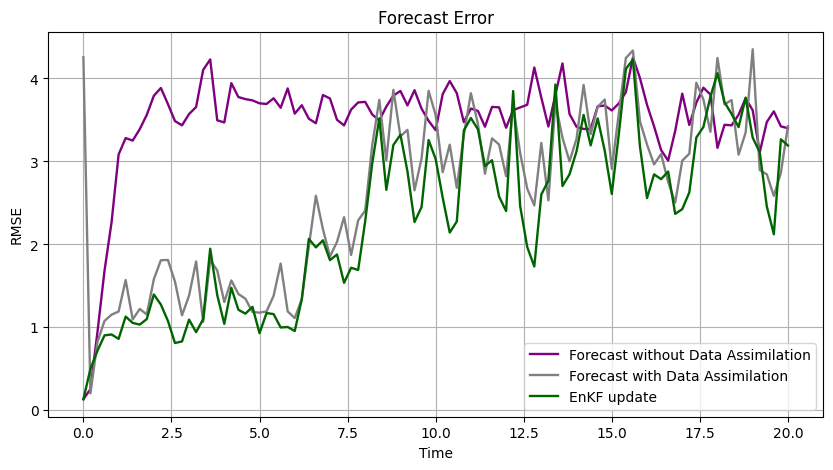

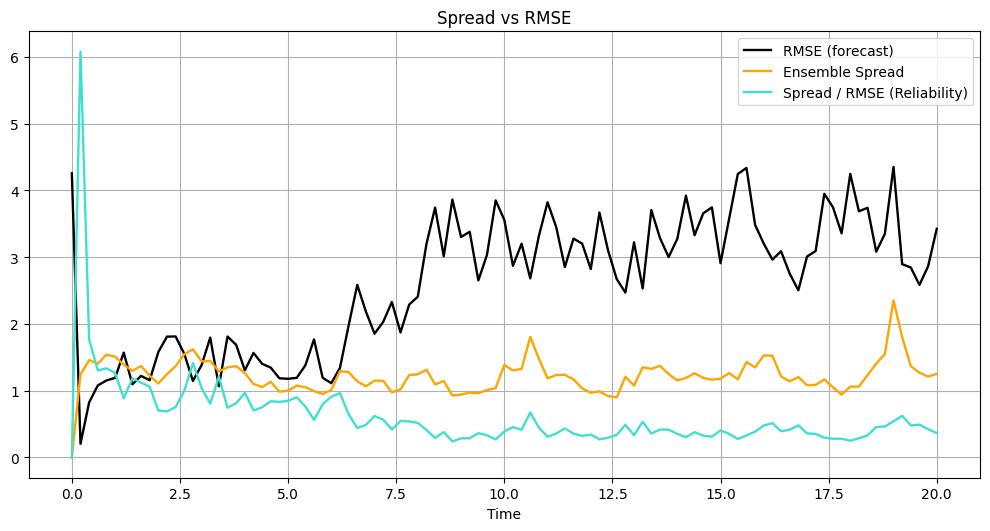

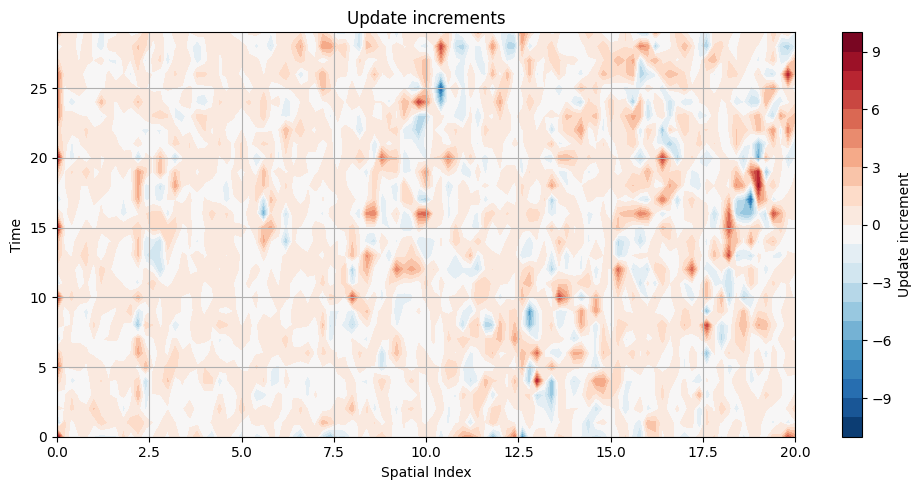

In [969]:
evaluation = evaluation(X_forecast_all, X_update_all, X_truth, t_truth)
rmse_free = ensemble_rmse(ensemble_mean(X_free_all), X_truth)
plot_rmse_comparison(evaluation, rmse_free)
plot_ensemble_spread(evaluation)
plot_update_increments(X_forecast_all, X_update_all, t_truth)



## Conclusion

From the RMSE Comparison plot we can observe that the model with data assimilation performing better than free forecasting in the beginning. However the benefit of data assimilation diminishes as the time progresses. 
From the Spread and RMSE comparison plot, we notice that the ensemble generally lower than RMSE in most of the time which represents the overconfidence of the model. The model underestimates the actual uncertainty in the state estimate. In the model the error covariance matrix $Q$ and $R$ were assumed to be constant but these usually change in real world situation. I want to approach this method again with covariance localization and implement data assimilation using machine learning to improve the reliability of the model.

## Reference: 

Brajard, J., Carrassi, A., Bocquet, M., and Bertino, L.: Combining data assimilation and machine learning to emulate a dynamical model from sparse and noisy observations: a case study with the Lorenz 96 model, Geosci. Model Dev. Discuss. [preprint], https://doi.org/10.5194/gmd-2019-136, 2019.

Brajard, Julien, et al. “Combining Data Assimilation and Machine Learning to Emulate a Dynamical Model from Sparse and Noisy Observations: A Case Study with the Lorenz 96 Model.” Journal of Computational Science, vol. 44, July 2020, p. 101171. Crossref, https://doi.org/10.1016/j.jocs.2020.101171.

B. Groenke, "Lorenz-96 Is Too Easy: Machine Learning Research Needs a More Realistic Toy Model," Data Science in Plain English, Medium, 2020. Accessed: Nov. 5, 2025. [Online]. Available: https://medium.com/data-science/lorenz-96-is-too-easy-machine-learning-research-needs-a-more-realistic-toy-model-6add938f6cc0

S. L. Green, "Numerical Integration — Runge Kutta 4th Order," Swarthmore College Control Systems Resource. Accessed: Nov. 5, 2025. [Online]. Available: https://lpsa.swarthmore.edu/NumInt/NumIntFourth.html

Roberts, C.D. & Leutbecher, M. (2025) Unbiased calculation, evaluation, and calibration of ensemble forecast anomalies. Quarterly Journal of the Royal Meteorological Society, 151(771), e4993. Available from: https://doi.org/10.1002/qj.4993

Evensen, G. (2009). Data Assimilation: The Ensemble Kalman Filter. Springer.

Whitaker, J. S., and A. F. Loughe, 1998: The Relationship between Ensemble Spread and Ensemble Mean Skill. Mon. Wea. Rev., 126, 3292–3302, https://doi.org/10.1175/1520-0493(1998)126<3292:TRBESA>2.0.CO;2.

Houtekamer, P. L., and H. L. Mitchell, 2001: A Sequential Ensemble Kalman Filter for Atmospheric Data Assimilation. Mon. Wea. Rev., 129, 123–137, https://doi.org/10.1175/1520-0493(2001)129<0123:ASEKFF>2.0.CO;2.

https://www.math.umd.edu/~slud/RITF17/enkf-tutorial.pdf 

https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/Mandel-enKF.pdf 